In [28]:
import requests
from bs4 import BeautifulSoup
import datetime
import sqlite3
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains

# Create or connect to SQLite database
conn = sqlite3.connect('jumia_products.db')
c = conn.cursor()

# Create table if it doesn't exist
c.execute('''
CREATE TABLE IF NOT EXISTS products (
    product_name TEXT,
    current_price TEXT,
    original_price TEXT,
    discount_percentage TEXT,
    rating TEXT,
    reviews TEXT
)
''')

# Base URL
base_url = 'https://www.jumia.co.ke/home-office-appliances/?tag=JMALL&sort=rating'

# Initialize WebDriver
driver = webdriver.Chrome()  # or use the appropriate WebDriver

# Function to extract data from a page
def extract_data(page_source):
    soup = BeautifulSoup(page_source, "html.parser")
    products = soup.find_all('div', class_='info')
    
    for product in products:
        try:
            product_name = product.find('h3', class_='name').text.strip()
            current_price = product.find('div', class_='prc').text.strip()
            original_price = product.find('div', class_='old').text.strip() if product.find('div', class_='old') else None
            discount_percentage = product.find('div', class_='bdg _dsct _sm').text.strip() if product.find('div', class_='bdg _dsct _sm') else None
            rating = product.find('div', class_='stars _s').text.strip() if product.find('div', class_='stars _s') else None
            reviews = product.find('div', class_='rev').text.strip() if product.find('div', class_='rev') else None
            
            # Insert data into the database
            c.execute('''INSERT INTO products ( product_name, current_price, original_price, discount_percentage, rating, reviews) 
                         VALUES ( ?, ?, ?, ?, ?, ?)''',
                      (product_name, current_price, original_price, discount_percentage, rating, reviews))
            conn.commit()
            
        except AttributeError:
            continue

# Function to scrape Jumia across all pages
def scrape_jumia():
    driver.get(base_url)
    time.sleep(5)  # Wait for the page to load
    
    while True:
        # Extract data from the current page
        extract_data(driver.page_source)
        
        try:
            # Find the 'Next' button using its class or link text and click it
            next_button = driver.find_element(By.CSS_SELECTOR, "a.pg[aria-label='Next Page']")
            ActionChains(driver).move_to_element(next_button).click().perform()
            
            # Wait for the next page to load
            time.sleep(5)
        except Exception as e:
            print(f"No more pages or error occurred: {e}")
            break

    # Close the WebDriver
    driver.quit()

# Start scraping
scrape_jumia()

# Select all from the table and print results
c.execute('''SELECT * FROM products''')
results = c.fetchall()
print(results)

# Close SQLite connection
conn.close()

No more pages or error occurred: Message: no such element: Unable to locate element: {"method":"css selector","selector":"a.pg[aria-label='Next Page']"}
  (Session info: chrome=128.0.6613.115); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7C5CEB5D2+29090]
	(No symbol) [0x00007FF7C5C5E689]
	(No symbol) [0x00007FF7C5B1B1CA]
	(No symbol) [0x00007FF7C5B6EFD7]
	(No symbol) [0x00007FF7C5B6F22C]
	(No symbol) [0x00007FF7C5BB97F7]
	(No symbol) [0x00007FF7C5B9672F]
	(No symbol) [0x00007FF7C5BB65D9]
	(No symbol) [0x00007FF7C5B96493]
	(No symbol) [0x00007FF7C5B609B1]
	(No symbol) [0x00007FF7C5B61B11]
	GetHandleVerifier [0x00007FF7C6008C5D+3295277]
	GetHandleVerifier [0x00007FF7C6054843+3605523]
	GetHandleVerifier [0x00007FF7C604A707+3564247]
	GetHandleVerifier [0x00007FF7C5DA6EB6+797318]
	(No symbol) [0x00007FF7C5C6980F]
	(No symbol) [0x00007FF7C5C653F4]
	(No

In [36]:
import pandas as pd
import sqlite3

def clean_percentage(value):
    """Remove percentage symbols from discount values."""
    if pd.isna(value):
        return 0.0
    return float(value.replace('%', '').strip())

def get_data():
    """Fetch data from the SQLite database and clean it."""
    conn = sqlite3.connect('jumia_products.db')
    query = 'SELECT * FROM products'
    df = pd.read_sql_query(query, conn)
    conn.close()

    # Clean data
    df['discount_percentage'] = df['discount_percentage'].apply(clean_percentage)

    # Handle missing data
    df = df.fillna({
        'current_price': 0,
        'original_price': 0,
        'discount_percentage': 0,
        'rating': 0,
        'reviews': 0
    })

    return df

if __name__ == '__main__':
    df = get_data()
    df.to_csv('cleaned_jumia_products.csv', index=False)

Descriptive Statistics:
       discount_percentage
count          2402.000000
mean             27.613239
std              17.426656
min               0.000000
25%              13.000000
50%              33.000000
75%              42.000000
max              58.000000


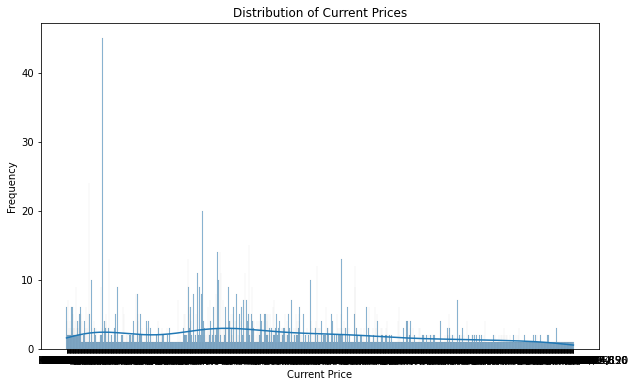

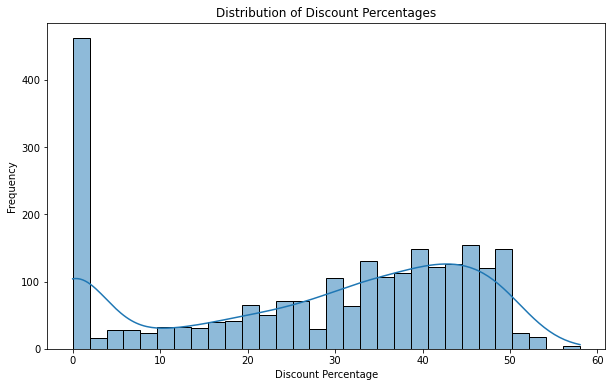

TypeError: can't multiply sequence by non-int of type 'float'

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load cleaned data
df = pd.read_csv('cleaned_jumia_products.csv')

# Descriptive Statistics
print("Descriptive Statistics:")
print(df.describe())

# Distribution Analysis
def plot_distribution(data, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    if len(data) > 1:  # Ensure there's more than one data point
        sns.histplot(data, bins=30, kde=True)
    else:
        print("Insufficient data to plot.")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# Plot price distribution
plot_distribution(df['current_price'], 'Distribution of Current Prices', 'Current Price', 'Frequency')

# Plot discount distribution
plot_distribution(df['discount_percentage'], 'Distribution of Discount Percentages', 'Discount Percentage', 'Frequency')

# Calculate Discounted Price
df['discounted_price'] = df['original_price'] * (1 - df['discount_percentage'] / 100)

# Correlation Analysis
correlation_matrix = df[['current_price', 'original_price', 'discount_percentage', 'discounted_price']].corr()
print("Correlation Matrix:")
print(correlation_matrix)

# Plot heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# Categorical Analysis
if 'category' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(y='category', data=df)
    plt.title('Distribution of Products Across Categories')
    plt.xlabel('Count')
    plt.ylabel('Category')
    plt.show()

    # Discounts by Category
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='category', y='discount_percentage', data=df)
    plt.title('Discounts by Category')
    plt.xlabel('Category')
    plt.ylabel('Discount Percentage')
    plt.xticks(rotation=45)
    plt.show()
    

In [ ]:
import streamlit as st
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

def clean_currency(value):
    """Remove currency symbols and commas from price values."""
    if pd.isna(value):
        return 0.0
    return float(value.replace('KSh ', '').replace(',', '').strip())

def clean_percentage(value):
    """Remove percentage symbols from discount values."""
    if pd.isna(value):
        return 0.0
    return float(value.replace('%', '').strip())

def get_data():
    """Fetch data from the SQLite database and clean it."""
    conn = sqlite3.connect('jumia_products.db')
    query = 'SELECT * FROM products'
    df = pd.read_sql_query(query, conn)
    conn.close()

    # Clean data
    df['current_price'] = df['current_price'].apply(clean_currency)
    df['original_price'] = df['original_price'].apply(clean_currency)
    df['discount_percentage'] = df['discount_percentage'].apply(clean_percentage)

    # Handle missing data
    df = df.fillna({
        'current_price': 0,
        'original_price': 0,
        'discount_percentage': 0,
        'rating': 0,
        'reviews': 0
    })

    return df

def main():
    # Set up the Streamlit app
    st.title('Jumia Products Data Dashboard')
    st.write("Explore and filter the Jumia products data.")

    # Load data
    df = get_data()

    # Sidebar filters
    st.sidebar.header('Filter Options')

    # Price filter
    min_price, max_price = st.sidebar.slider(
        'Select Price Range',
        min_value=float(df['current_price'].min()),
        max_value=float(df['current_price'].max()),
        value=(float(df['current_price'].min()), float(df['current_price'].max()))
    )
    filtered_df = df[(df['current_price'] >= min_price) & (df['current_price'] <= max_price)]

    # Discount filter
    min_discount, max_discount = st.sidebar.slider(
        'Select Discount Range',
        min_value=float(df['discount_percentage'].min()),
        max_value=float(df['discount_percentage'].max()),
        value=(float(df['discount_percentage'].min()), float(df['discount_percentage'].max()))
    )
    filtered_df = filtered_df[(filtered_df['discount_percentage'] >= min_discount) & (filtered_df['discount_percentage'] <= max_discount)]

    # Display filtered data
    st.write(f"Displaying {len(filtered_df)} products")
    st.dataframe(filtered_df)

    # Visualizations
    st.subheader('Price Distribution')
    fig, ax = plt.subplots()
    sns.histplot(filtered_df['current_price'], bins=30, kde=True, ax=ax)
    st.pyplot(fig)

    st.subheader('Discount Distribution')
    fig, ax = plt.subplots()
    sns.histplot(filtered_df['discount_percentage'], bins=30, kde=True, ax=ax)
    st.pyplot(fig)

    # Calculate and plot discount vs. price
    filtered_df['discounted_price'] = filtered_df['original_price'] * (1 - filtered_df['discount_percentage'] / 100)
    st.subheader('Discount vs. Price')
    fig, ax = plt.subplots()
    sns.scatterplot(data=filtered_df, x='current_price', y='discounted_price', ax=ax)
    ax.set_title('Discounted Price vs. Current Price')
    st.pyplot(fig)

if __name__ == '__main__':
    main()